# A faster kernel-based OT estimator
This notebook presents and reimplements the results from https://doi.org/10.48550/arXiv.2310.14087

In [ ]:
import jax
import jax.numpy as jnp
from jax import jit

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython import display
from tqdm.notebook import tqdm

import ott
import ot

## Litterature review

### Framework

Given two samples $\{x_i\}$ and $\{y_i\}$ from $\mu$ and $\nu$, let's estimate the Wasserstein distance (with quadratic cost) $W_2(\mu,\nu)$.

### The curse of dimensionality

The first naive option is to use the plug-in estimator:
We approximate $\mu$ and $\nu$ using $\hat{\mu} = \frac{1}{n} \Sigma_i \delta_{x_i}$ and $\hat{\nu} = \frac{1}{n} \Sigma_i \delta_{y_i}$, and compute $\hat{W} = W(\hat{\mu},\hat{\nu})$ using linear programming (algorithmic complexity $O(n^3)$).
This estimator converges with a statistical error rate $O(n^{-2/d})$ with $d$ the dimension (for $d$ greater than 4, see Chizat et al. reference). The presence of the dimension in the exponent is called $\textbf{the curse of dimensionality}$.

Let's take a look at this phenomenon in action. We use gaussian distributions, for which the Wasserstein distance has a closed form:  
$$W_2^2=\left\|m_1-m_2\right\|_2^2+\operatorname{Tr}\left(\Sigma_1+\Sigma_2-2\left(\Sigma_1^{1 / 2} \Sigma_2 \Sigma_1^{1 / 2}\right)^{1 / 2}\right)$$

In [ ]:
# Parameters
rng = jax.random.PRNGKey(25)
rng1, rng2 = jax.random.split(rng)

dims, n_samples, n_repeat = [4,7,10], [100,330, 1000,3300], 10 # change dims ?

# Utils
@jit
def get_matrix_sqrt(A):
    eigvals, eigvecs = jnp.linalg.eigh(A)
    return eigvecs @ jnp.diag(jnp.sqrt(eigvals)) @ eigvecs.T

def get_groundtruth_from_gaussian(src,tgt):
    """Return the squared groundtruth Wasserstein distance between two Gaussians."""
    mu1,sigma1, mu2, sigma2 = src.loc, src.covariance(), tgt.loc, tgt.covariance()
    _ = get_matrix_sqrt(sigma1)
    _ = get_matrix_sqrt(_@sigma2@_)
    return (jnp.linalg.norm(mu1-mu2)**2 + jnp.trace(sigma1+sigma2-2*_)) # **0.5

def plugin_estimator(src_sample,tgt_sample):
    """Return the squared plugin estimate of the Wasserstein distance between two samples."""
    M = jnp.linalg.norm(src_sample[:,None]-tgt_sample[None,:],axis=-1)**2
    gamma = ot.emd([],[],np.array(M))
    return (jnp.sum(gamma*M)) # **0.5

def entropic_estimator(X,Y):
    """Return the squared entropic estimator of the Wasserstein distance between two samples."""
    # Solve via Sinkhorn
    geom = ott.geometry.pointcloud.PointCloud(X, Y)  # Define an euclidean geometry
    problem = ott.problems.linear.linear_problem.LinearProblem(geom)  # Define your problem
    solver = ott.solvers.linear.sinkhorn.Sinkhorn()  # Select the Sinkhorn solver
    out = solver(problem)
    entopic_estim = out.primal_cost
    return entopic_estim

In [ ]:
# The curse of dimensionality
errors = []

for dim in dims:
    print(f"Dimension {dim}")
    
    # Generate random gaussians
    src = ott.tools.gaussian_mixture.gaussian.Gaussian.from_random(rng1,dim,stdev_mean=0.5)
    tgt = ott.tools.gaussian_mixture.gaussian.Gaussian.from_random(rng2,dim,stdev_mean=0.5)

    # Groundtruth
    groundtruth = get_groundtruth_from_gaussian(src,tgt)

    # Plug-in estimators
    for n_sample in tqdm(n_samples):
        rng_keys = jax.random.split(rng,n_repeat)

        # Repeat
        for n in range(n_repeat):
            rng_key = rng_keys[n]
            src_sample,tgt_sample = src.sample(rng_key,n_sample), tgt.sample(rng_key,n_sample)
            estimate = plugin_estimator(src_sample,tgt_sample)
            error = jnp.abs(estimate-groundtruth)
            errors.append({'dim':dim,'n_sample':n_sample,'error':error})

# Format
errors = pd.DataFrame(errors)
errors['error'] = errors['error'].astype(float)
errors['log_error'] = np.log(errors['error'])
errors['log_n_sample'] = np.log10(errors['n_sample'])

Dimension 4


  0%|          | 0/4 [00:00<?, ?it/s]

c:\Users\Paul\.conda\envs\ot\Lib\site-packages\ot\lp\__init__.py:354: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


Dimension 7


  0%|          | 0/4 [00:00<?, ?it/s]

Dimension 10


  0%|          | 0/4 [00:00<?, ?it/s]

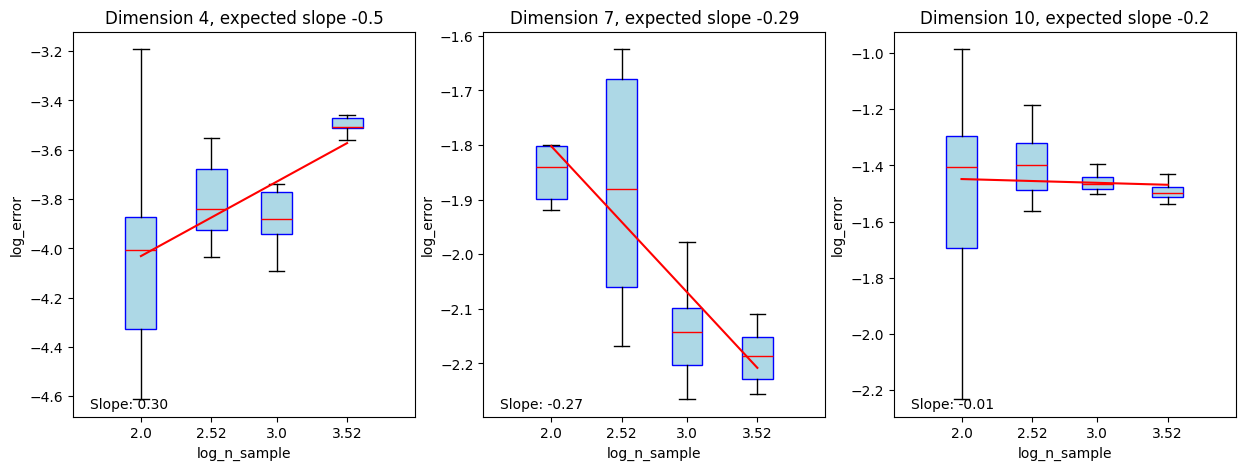

In [ ]:
# Plot
fig, axes = plt.subplots(1, len(dims), figsize=(15, 5))
boxplot_kwargs = {
    "showfliers": False,
    "patch_artist": True,
    "boxprops": {"facecolor": 'lightblue', "color": 'blue'},
    "whiskerprops": {"color": 'black'},
    "capprops": {"color": 'black'},
    "medianprops": {"color": 'red'}
}

for dim in dims:
    ax = axes[dims.index(dim)]
    data = errors[errors['dim']==dim]
    
    # Boxplot
    x = data['log_n_sample'].unique()
    y = data['log_error'].groupby(data['log_n_sample']).apply(list)
    ax.boxplot(y, positions = x, **boxplot_kwargs)
    x_ticks = [round(_, 2) for _ in x]
    ax.set_xticklabels(x_ticks)
    
    # Regression line
    x = data['log_n_sample']
    y = data['log_error']
    m, b = np.polyfit(x, y, 1) # Fit a linear regression line
    ax.plot(x, m*x + b, color='red') # Plot the regression line
    ax.text(0.05, 0.05, f"Slope: {m:.2f}", transform=ax.transAxes, ha='left', va='top', fontsize=10, color='black')
    
    ax.set_title(f"Dimension {dim}, expected slope {round(-2/dim,2)}")
    ax.set_xlabel("log_n_sample")
    ax.set_ylabel("log_error")

plt.show()

### Regularizations

To overcome this issue, several alternatives have been proposed. We present two of them:
- $\textbf{Entropic regularization}$: by adding an entropic penalty term with a factor $\epsilon$, the estimator has a statistical error rate of $O(\epsilon^{-d/2} n^{-1/2})$ and a computational complexity of $O(n^2)$.
- $\textbf{Low-dimensional projection}$: if the two distribution differ on a subspace of low dimension $k$, there exist an estimator with statistical error rate $O(n^{-1/k})$, but the conjecture is that there is no polynomial-time algorithm for such estimators (in the spiked transport model). This is a case of a statistical-computational gap.

### Leveraging smoothness

Another reasonable hypothesis is to consider the smoothness of the distribution. An important contibution in that direction is the paper $\textit{A Dimension-free Computational Upper-bound for Smooth Optimal Transport Estimation}$ from Vacher et al.  
This paper bridges the statistical-computational gap of smooth OT estimator and proposes an estimator with a statistical error rate of $O(n^{-1/2})$ and a computational complexity $O(n^{1/2 ~max(4,\frac{7d}{m-d})})$ ($m$ being the smoothness parameter).

### A computational improvment: from SSIPM to SSN

The estimator is based on a dual, RKHS, discretized reformulation of the problem:
$$\min _{\gamma \in \mathbb{R}^{\ell}} \frac{1}{4 \lambda_2} \gamma^{\top} \mathbf{Q} \gamma-\frac{1}{2 \lambda_2} \sum_{j=1}^{\ell} \gamma_j z_j+\frac{q^2}{4 \lambda_2} \quad \text { such that } \quad \sum_{j=1}^{\ell} \gamma_j \Phi_j \Phi_j^{\top}+\lambda_1 \mathbf{I}_{\ell} \succeq 0$$
and $$\widehat{\mathrm{OT}}=\frac{q^2}{2 \lambda_2}-\frac{1}{2 \lambda_2} \sum_{j=1}^{\ell} \hat{\gamma}_j\left(\hat{w}_\mu\left(\tilde{x}_j\right)+\hat{w}_\nu\left(\tilde{y}_j\right)\right)$$

Its computation relies on the SSIPM method, which solves the later problem using a barrier term:
$$
\begin{gathered}
\left.\min _{\gamma \in \mathbb{R}^{\ell}} \frac{1}{4 \lambda_2} \gamma^{\top} \mathbf{Q} \gamma-\frac{1}{2 \lambda_2} \sum_{j=1}^{\ell} \gamma_j z_j+\frac{q^2}{4 \lambda_2}-\frac{\delta}{\ell} \log \operatorname{det}\left(\sum_{i=1}^{\ell} \gamma_i \Phi_i \Phi_i^{\top}+\lambda_1 \mathbf{I}_{\ell}\right)\right) \\
\text { such that } \sum_{j=1}^{\ell} \gamma_j \Phi_j \Phi_j^{\top}+\lambda_1 \mathbf{I}_{\ell} \succeq 0 .
\end{gathered}$$

In [ ]:
# Samples
dim, n_sample = 5, 200

rng = jax.random.PRNGKey(14)
rng1, rng2 = jax.random.split(rng)

src = ott.tools.gaussian_mixture.gaussian.Gaussian.from_random(rng1,dim,stdev_mean=2e-1,stdev_cov=1e-2,ridge=0.5)
tgt = ott.tools.gaussian_mixture.gaussian.Gaussian.from_random(rng2,dim,stdev_mean=2e-1,stdev_cov=1e-2,ridge=0.5)
X, Y = src.sample(rng1, n_sample), tgt.sample(rng2, n_sample)

# Groundtruth Wasserstein distance
groundtruth = get_groundtruth_from_gaussian(src,tgt)

# Plugin estimator
estimate_plugin = plugin_estimator(X,Y)

# Entropic estimator
estimate_entropic = entropic_estimator(X,Y)

# Filling samples
from sobol_seq import i4_sobol_generate
n_fill = 5*n_sample # TO BE INVESTIGATED
sob = i4_sobol_generate(2*dim, n_fill, skip=3000)
X_fill = sob[:, :dim]
Y_fill = sob[:, dim:]

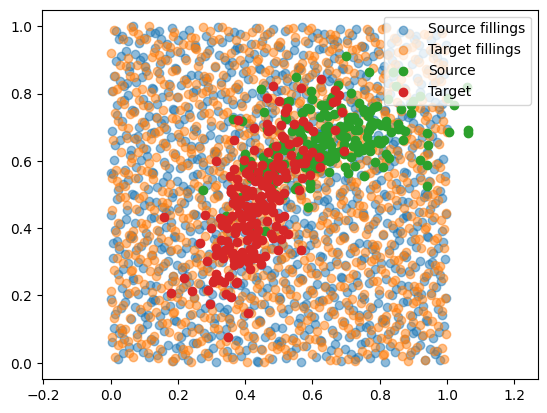

In [ ]:
# Plot
plt.scatter(X_fill[:,0],X_fill[:,1],label='Source fillings',alpha=0.5)
plt.scatter(Y_fill[:,0],Y_fill[:,1],label='Target fillings',alpha=0.5)
plt.scatter(X[:,0],X[:,1],label='Source')
plt.scatter(Y[:,0],Y[:,1],label='Target')
plt.legend()
plt.axis('equal')
plt.show()

In [ ]:
# A usecase of the SSIPM algorithm, based on https://github.com/BorisMuzellec/kernel-sos-ot.git
from utils import make_kernels, transport_cost
from optim import interior_point

# Kernels
kernel = "gaussian"
l = 0.1
Phi, M, Kx1, Ky1, Kx2, Ky2, Kx3, Ky3 = make_kernels(
    X, Y, X_fill, Y_fill, l=l, kernel=kernel
)

# Regularization parameters
lbda_1 = 1 / n_sample
lbda_2 = 1 / n_fill**0.5  # TO BE INVESTIGATED

# Optimization problem parameters
eps_start = n_sample
eps_end = 1e-8
tau = 1e-8
niter = 1000

# SSIPM
G, eps = interior_point(
    M,
    Phi,
    Kx1,
    Kx2,
    Kx3,
    Ky1,
    Ky2,
    Ky3,
    lbda_1=lbda_1,
    lbda_2=lbda_2,
    eps_start=eps_start,
    eps_end=eps_end,
    eps_div=2,
    tau=tau,
    niter=niter,
    verbose=True,
    report_interval=100,
)
kernel_sos_ot = transport_cost(G, Kx2, Kx3, Ky2, Ky3, lbda_2, product_sampling=False)

# Result
print(f"Groundtruth: {groundtruth}")
print(f"Plugin estimate: {estimate_plugin}")
print(f"Entropic estimate: {estimate_entropic}")
print(f"SSIPM estimate: {kernel_sos_ot}")

iter 1:	transport: 9.87e+00	decr: 4.45e+02	eps: 2.00e+02
iter 101:	transport: -1.38e+02	decr: 4.16e+02	eps: 2.00e+02
iter 201:	transport: -3.58e+02	decr: 7.04e+01	eps: 5.00e+01
iter 301:	transport: -8.01e+01	decr: 1.72e+01	eps: 3.12e+00
iter 401:	transport: -1.08e+01	decr: 3.48e+00	eps: 1.95e-01
iter 501:	transport: 2.54e+00	decr: 6.28e-02	eps: 1.22e-02
iter 601:	transport: 2.02e+00	decr: 9.95e-02	eps: 3.81e-04
iter 701:	transport: 1.92e+00	decr: 1.28e-06	eps: 5.96e-06
iter 754:	transport: 1.92e+00	decr: 1.66e-10	eps: 5.82e-09
Precision 1.00e-08 reached in 2.09e+02 seconds
Groundtruth: 0.20026326179504395
Plugin estimate: 0.1977711021900177
Entropic estimate: 0.214930921792984
SSIPM estimate: 1.918149344097217


The paper $\textit{A Specialized Semismooth Newton Method for Kernel-Based Optimal Transport}$ proposes a new algorithm based on a semi-smooth Newton method.  
The algorithm solves:  
$$ \min _{\gamma \in \mathbb{R}^n} \max _{X \in \mathcal{S}_{+}^n} \frac{1}{4 \lambda_2} \gamma^T Q \gamma-\frac{1}{2 \lambda_2} \gamma^T z+\frac{q^2}{4 \lambda_2}-\left\langle X, \Phi^{\star}(\gamma)+\lambda_1 I\right\rangle $$ 
which is a convex optimization problem.
Let's reformulate:
$$ \min _{\gamma \in \mathbb{R}^n} \max _{X \in \mathcal{S}_{+}^n} F(\gamma,X) $$
A solution can be formulated with a variational inequality:  
$$ (\hat{\gamma},\hat{X}) \text{ s.t. } 
\bigg\langle \begin{pmatrix}
\partial_\gamma F (\hat{\gamma},\hat{X}) \\
-\partial_X F (\hat{\gamma},\hat{X}) \\
\end{pmatrix}, 
\begin{pmatrix}
\gamma-\hat{\gamma} \\
X-\hat{X} \\
\end{pmatrix} \bigg\rangle
\geq 0
$$ 
Let $R = 
\begin{pmatrix}
\partial_\gamma F\\
Id - proj(Id-\partial_X F)\\
\end{pmatrix}$  
A solution is a root of $R$, and $R$ is strongly semismooth.  
This problem can be solved using the EG algorithm, which is later used as a safeguard.

In [ ]:
from ssn import KernelOT, get_gaussian_kernel_func
bandwidth = 0.1
gaussian_kernel = get_gaussian_kernel_func(bandwidth)
kot = KernelOT(X, Y, gaussian_kernel)

# A usecase of the EG algorithm
N = n_sample + n_sample**2
v0 = np.ones(N) / N
w_eg,r_norms_eg = kot.run_eg(v0) # error=1e-2, max_iter=20, verbose=False
ot_from_eg = kot.get_OT_from_gamma(w_eg[0])

# Result
print(f"EG estimate: {ot_from_eg}")

The algorithm did not converge in 100 steps.
EG estimate: 0.35289421677589417


The EG algorithm converge at a rate $O(\frac{1}{\sqrt{k}})$:

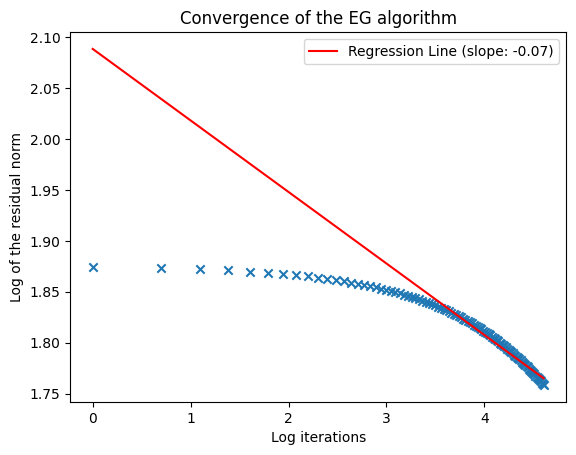

In [ ]:
# Plot
x = np.log(np.arange(len(r_norms_eg))+1)
y = np.log(r_norms_eg)
plt.scatter(x,y, marker='x')

burn = 30
m, b = np.polyfit(x[burn:], y[burn:], 1)
plt.plot(x, m*x + b, color='red', label=f'Regression Line (slope: {m:.2f})')
plt.legend()

plt.title("Convergence of the EG algorithm")
plt.xlabel("Log iterations")
plt.ylabel("Log of the residual norm")
plt.show()

The SSN algorithm computationally improves the convergence in several ways.

Results about the complexity:
- Local quadratic rate in the number of iterations, use EG safeguard
- Inversion of a $n$ x $n$ matrix instead of $n+n^2$ x $n+n^2$.

In [ ]:
# A usecase of the SSN algorithm
v = kot.run_ssn(v0,1.) # error=1e-2, max_iter=20, verbose=False
ot_from_ssn = kot.get_OT_from_gamma(v[:n_sample])

# Result
print(f"SSN estimate: {ot_from_ssn}")

The algorithm converged in 88 steps.


TypeError: unsupported operand type(s) for *: 'tuple' and 'ArrayImpl'